In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from sklearn.cluster import AgglomerativeClustering

torch.manual_seed(42)
np.random.seed(42)

### Data

We will be working with the EMNIST data set of Handwritten characters.

In [2]:
data = datasets.EMNIST(root=".", split="byclass", download=True, transform=transforms.ToTensor())

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

n_classes = data.train_labels.numpy().max()+1

print(data, "\n\n# classes: {}".format(n_classes))

Dataset EMNIST
    Number of datapoints: 697932
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor() 

# classes: 62


/home/sattler/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
def split_noniid(train_idcs, train_labels, alpha, n_clients):
    '''
    Splits a list of data indices $train_idcs with corresponding labels
    $train_lables into $n_clients subsets according to a dirichlet distribution with parameter
    $alpha
    '''
    n_classes = train_labels.max()+1
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)

    class_idcs = [np.argwhere(train_labels[train_idcs]==y).flatten() 
           for y in range(n_classes)]

    client_idcs = [[] for _ in range(n_clients)]
    for c, fracs in zip(class_idcs, label_distribution):
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]
  
    return client_idcs

In [4]:
class CustomSubset(Subset):
    '''A custom subset class with modifiable transform'''
    def __init__(self, dataset, indices, subset_transform=None):
        super().__init__(dataset, indices)
        self.subset_transform = subset_transform
        
    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        
        if self.subset_transform:
            x = self.subset_transform(x)
      
        return x, y        

### Model

To classify the characters from the EMNIST data set we will use a five-layer convolutional neural network (CNN).

In [5]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 62)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Federated Learning Utils

In [6]:
def train_op(model, loader, optimizer, epochs=1, verbose=False):
    model.train()  
    for ep in range(epochs):
        running_loss, samples = 0.0, 0
        for x, y in loader:   
            optimizer.zero_grad()

            loss = torch.nn.CrossEntropyLoss()(model(x), y)
            running_loss += loss.item()*y.shape[0]
            samples += y.shape[0]

            loss.backward()
            optimizer.step()  
        if verbose:
            print("Epoch: {} -> Loss: {:.2f}".format(ep+1, running_loss / samples))
    return running_loss / samples
      
def eval_op(model, loader):
    model.train()
    samples, correct = 0, 0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            y_ = model(x)
            _, predicted = torch.max(y_.data, 1)

            samples += y.shape[0]
            correct += (predicted == y).sum().item()

    return correct/samples

In [7]:
def copy(target, source):
    for name in target:
        target[name].data = source[name].data.clone()
    
def subtract_(target, minuend, subtrahend):
    for name in target:
        target[name].data = minuend[name].data.clone()-subtrahend[name].data.clone()
    
def reduce_add_average(targets, sources):
    for target in targets:
        for name in target:
            tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
            target[name].data += tmp
        
def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])


def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)

    return angles.numpy()


        
class FederatedTrainingDevice(object):
    def __init__(self, model_fn, data):
        self.model = model_fn()
        self.data = data
        self.W = {key : value for key, value in self.model.named_parameters()}


    def evaluate(self, loader=None):
        return eval_op(self.model, self.eval_loader if not loader else loader)
  
  
class Client(FederatedTrainingDevice):
    def __init__(self, model_fn, optimizer_fn, data, idnum, batch_size=128, train_frac=0.8):
        super().__init__(model_fn, data)  
        self.optimizer = optimizer_fn(self.model.parameters())
            
        self.data = data
        n_train = int(len(data)*train_frac)
        n_eval = len(data) - n_train 
        data_train, data_eval = torch.utils.data.random_split(self.data, [n_train, n_eval])

        self.train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
        self.eval_loader = DataLoader(data_eval, batch_size=batch_size, shuffle=False)
        
        self.loader = DataLoader(self.data, batch_size=batch_size, shuffle=True)
        self.id = idnum
        
        self.dW = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}
        self.W_old = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}
        
    def synchronize_with_server(self, server):
        copy(target=self.W, source=server.W)
    
    def compute_weight_update(self, epochs=1, loader=None):
        copy(target=self.W_old, source=self.W)
        train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
        subtract_(target=self.dW, minuend=self.W, subtrahend=self.W_old)
        return train_stats  

    def reset(self): 
        copy(target=self.W, source=self.W_old)
    
    
class Server(FederatedTrainingDevice):
    def __init__(self, model_fn, data):
        super().__init__(model_fn, data)
        self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
    
    def select_clients(self, clients, frac=1.0):
        return random.sample(clients, int(len(clients)*frac)) 
    
    def aggregate_weight_updates(self, clients):
        reduce_add_average(target=self.W, sources=[client.dW for client in clients])
        
    def compute_pairwise_similarities(self, clients):
        return pairwise_angles([client.dW for client in clients])
  
    def cluster_clients(self, S):
        clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)

        c1 = np.argwhere(clustering.labels_ == 0).flatten() 
        c2 = np.argwhere(clustering.labels_ == 1).flatten() 
        return c1, c2
    
    def aggregate_clusterwise(self, client_clusters):
        for cluster in client_clusters:
            reduce_add_average(targets=[client.W for client in cluster], 
                               sources=[client.dW for client in cluster])
            
            
    def compute_max_update_norm(self, cluster):
        return np.max([torch.norm(flatten(client.dW)).item() for client in cluster])

    
    def compute_mean_update_norm(self, cluster):
        return torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]), 
                                     dim=0)).item()



Lets assigne some non-iid data to the clients. Below we display the distribution, every color is one client. 

In [8]:
data = datasets.EMNIST(root=".", split="byclass", download=True)

idcs = np.random.permutation(len(data))
train_idcs, test_idcs = idcs[:50000], idcs[50000:60000]
train_labels = data.train_labels.numpy()

client_idcs = split_noniid(train_idcs, train_labels, alpha=2.0, n_clients=10)

client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

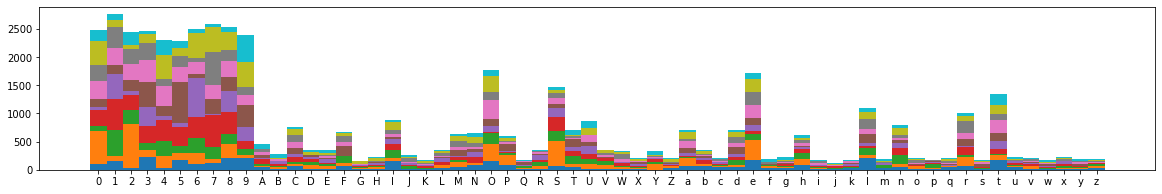

In [9]:
plt.figure(figsize=(20,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1))
plt.xticks(np.arange(62), mapp)
plt.show()

We make the clients incongruent by rotating the data for half of the clients by 90 degrees

In [10]:
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((90,90)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

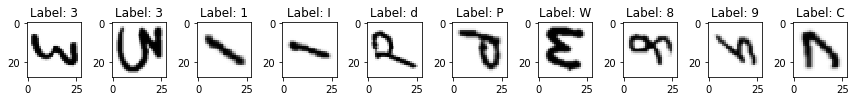

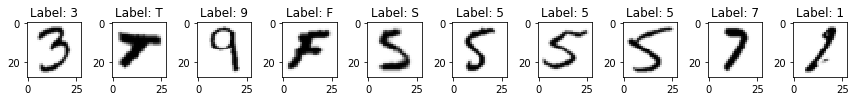

In [11]:
for client in [0,5]:
    viz_loader = DataLoader(client_data[client], batch_size=128, shuffle=True)
    x, y = iter(viz_loader).next()

    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

In [12]:
clients = [Client(ConvNet, torch.optim.Adam, data, idnum=i) 
           for i, data in enumerate(client_data)]
server = Server(ConvNet, test_data)

In [13]:
COMMUNICATION_ROUNDS = 40
EPS_1 = 0.4
EPS_2 = 1.2
    
    
idccs = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in idccs]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    print("Communication Round: {}".format(c_round))

    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()


    similarities = server.compute_pairwise_similarities(clients)


    idccs_new = []
    for idc in idccs:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        print("Cluster {}: max_norm {:.2f}, mean_norm {:.2f}".format(idc, max_norm, mean_norm))
             
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2:
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            alpha_cross_max = np.max(similarities[idc[c1]][:,idc[c2]])
            idccs_new += [c1, c2]
            
            print("--- SPLIT ---")    


        else:
            idccs_new += [idc]

    idccs = idccs_new
    client_clusters = [[clients[i] for i in idcs] for idcs in idccs]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]

    print("Client Mean Accuracy: {}".format(np.mean(acc_clients)))
    print()

Communication Round: 1
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 2.78, mean_norm 1.15
Client Mean Accuracy: 0.0475640210427956

Communication Round: 2
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 2.81, mean_norm 0.86
Client Mean Accuracy: 0.06954849345097495

Communication Round: 3
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 3.16, mean_norm 0.87
Client Mean Accuracy: 0.09885235595593442

Communication Round: 4
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 3.31, mean_norm 1.02
Client Mean Accuracy: 0.13588821279777624

Communication Round: 5
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 3.04, mean_norm 1.01
Client Mean Accuracy: 0.1791156434364105

Communication Round: 6
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 2.71, mean_norm 0.90
Client Mean Accuracy: 0.2174186283562412

Communication Round: 7
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 2.31, mean_norm 0.77
Client Mean Accuracy: 0.24161427655491252

Communication Round: 8
Cluster [0 1 2 3 4 5 6 7 8 9]: max_norm 2.00, mean_norm 0.65
Client Mean Accuracy: 0.272728